This notebook includes the code of a two-module model that takes an input image as cow,dog or horse(from ETH80 dataset),
then after applying a temporal segmentation on the input(DoG gaussian filters). it is processed through a spiking neural netwrok.

At the cell below the first module, namely the convolutional spiking neural network is defined.

Class labels=
{0: cow, 
1: dog, 
2: horse}

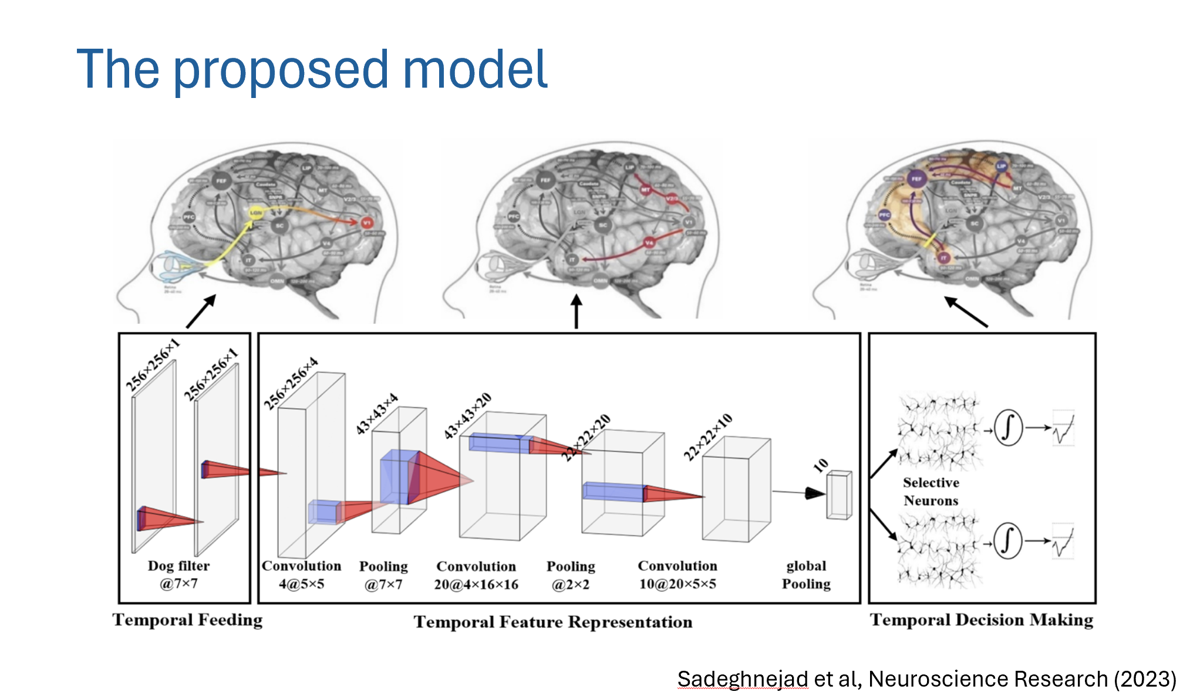

In [ ]:
from PIL import Image as PILImage
from IPython.display import display

img = PILImage.open("proposed_model_fig.png")
resized_img = img.resize((1200, 700)) 
display(resized_img)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
import numpy as np
from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
from torchvision import transforms
import matplotlib.pyplot as plt

import os
from PIL import Image

# Path to the folder containing images

# List to store the loaded images
dict_folder={0:"training_images/cow", 1:"training_images/dog",
              2:"training_images/horse"}


image_list = []

# # Loop through all files in the folder

for key in dict_folder.keys():
    for filename in os.listdir(dict_folder[key]):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(dict_folder[key], filename)
            img = Image.open(img_path)
            img=img.convert("L")
            image_list.append((img,key))


class S1Transform:
    def __init__(self, filter, timesteps = 15):
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
    def __call__(self, image):
        
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

kernels = [ utils.DoGKernel(7,1,2),
            utils.DoGKernel(7,2,1),]
filter = utils.Filter(kernels, padding = 0, thresholds = 50)
s1 = S1Transform(filter)      


data_tensor=[]
data_label=[]

for (img,label) in image_list:

    data_tensor.append(s1(img))
    data_label.append(torch.tensor(label))

#the model runs faster on GPU-integrated systems, however if there's no GPU use_cuda should be set to False
use_cuda=False

######################################################
class Kheradpisheh_SNN(nn.Module):
    def __init__(self):
        super(Kheradpisheh_SNN, self).__init__()

        self.conv1 = snn.Convolution(2, 32, 5, 0.8, 0.05)
        self.conv1_t = 6
        self.k1 = 10
        self.r1 = 2

        self.conv2 = snn.Convolution(32, 150, 5, 0.8, 0.05)
        self.conv2_t = 2
        self.k2 = 100
        self.r2 = 1

        self.conv3 = snn.Convolution(150, 60, 5, 0.8, 0.05)
        self.conv3_t = 1
        self.k3 = 60
        self.r3 = 1
        
        self.stdp1 = snn.STDP(self.conv1, (0.008, -0.001))
        self.stdp2 = snn.STDP(self.conv2, (0.03, -0.001))
        self.stdp3 = snn.STDP(self.conv3, (0.03, -0.001))
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0
        self.spk_cnt3 = 0
    
    def save_data(self, input_spike, potentials, output_spikes, winners):
        self.ctx["input_spikes"] = input_spike
        self.ctx["potentials"] = potentials
        self.ctx["output_spikes"] = output_spikes
        self.ctx["winners"] = winners

    def forward(self, input, max_layer=None):
        input = sf.pad(input.float(), (2,2,2,2), 0)
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.save_data(input, pot, spk, winners)
                return spk, pot
            spk_in = sf.pad(sf.pooling(spk, 3, 3, 1), (1,1,1,1))
            spk_in = sf.pointwise_inhibition(spk_in)
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.save_data(spk_in, pot, spk, winners)
                return spk, pot

            spk_in = sf.pad(sf.pooling(spk, 3, 3, 1), (1,1,1,1))
            spk_in = sf.pointwise_inhibition(spk_in)
            pot = self.conv3(spk_in)
            spk, pot = sf.fire(pot, self.conv3_t, True)    
            if max_layer == 3:
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k3, self.r3, spk)
                self.save_data(spk_in, pot, spk, winners)
                return spk, pot    
            
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_1=sf.pooling(spk, 3, 3, 1)
            pot = self.conv2(sf.pad(spk_1, (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_2 = sf.pooling(spk, 3, 3, 1)
            pot = self.conv3(sf.pad(spk_2, (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv3_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_3 = sf.pooling(spk, 3, 3, 1)

            return spk_3,spk_2,spk_1
    
    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 3:
            self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])    
            
    ##################################################
    
def train_unsupervise(network, data, layer_idx):
    network.train()
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def test(network, data, target, layer_idx):
    network.eval()
    ans = [None] * len(data)
    t = [None] * len(data)
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        output,_ = network(data_in, layer_idx).max(dim = 0)
        ans[i] = output.reshape(-1).cpu().numpy()
        t[i] = target[i]
    return np.array(ans), np.array(t)

   
data=TensorDataset(torch.stack(data_tensor),torch.stack(data_label))

#here I split the data so that with train_set the linear filters could be extracted through a supervised averaging over each class images

from sklearn.model_selection import train_test_split

train_dataset, test_dataset= train_test_split(data,test_size=0.15, shuffle=True,random_state=42,stratify=torch.stack(data_label))

train_dataset=utils.CacheDataset(train_dataset)
test_dataset=utils.CacheDataset(test_dataset)


train_data=[train_dataset[i][0] for i in range(len(train_dataset))]
train_labels=[train_dataset[i][1] for i in range(len(train_dataset))]
test_data=[test_dataset[i][0] for i in range(len(test_dataset))]
test_labels=[test_dataset[i][1] for i in range(len(test_dataset))]

At the cell below, I've created a 3class DDM model that takes the output of the first module as input currents and by solving linear/nonlinear rate models for firing rate reaches one of the classes decision boundary. When a boundary is touched the process is terminated, decision time, accuracy and confidence of the mad decision are saved.

In [ ]:
#define the class for integrating two modules together
import copy

#the module is programmed as a class that takes the SNN model as an input 
class Visual_3class_DDM:
    
    def __init__(self,model,f_dict=None,frame_duration=0.1,dt=0.001):

        self.f_dict=f_dict    
        self.snn=copy.deepcopy(model)
        self.dt=dt
        self.frame_duration=frame_duration
        

    def fit_linear_features(self, train_dataset):

        sample_data=[train_dataset[i][0] for i in range(len(train_dataset))]
        labels=np.array([train_dataset[i][1] for i in range(len(train_dataset))])
        images_ordered=[torch.tensor(np.array(sample_data)[labels==0]),torch.tensor(np.array(sample_data)[labels==1]),torch.tensor(np.array(sample_data)[labels==2])]

        output_dict={"0":[], "1":[], "2":[]}
        self.snn.eval()
        for key in output_dict.keys():
            for i in range(len(images_ordered[int(key)])):
                data=images_ordered[int(key)][i]
                output_dict[key].append(self.snn(data)[0].cpu().numpy().reshape(15,-1))
        
            output_dict[key]=np.array(output_dict[key]) 
        
        
        f_dict={}
        
        for key in output_dict.keys():
        
            arr=np.array(output_dict[key])
            f_dict[key]=arr.mean(axis=0)[-1]
            f_dict[key]=f_dict[key]/np.linalg.norm(f_dict[key])

        self.f_dict=f_dict


    def input_current_calculator(self,input_sample):

        frame_duration=self.frame_duration
        dt=self.dt
        f0=self.f_dict["0"]
        f1=self.f_dict["1"]
        f2=self.f_dict["2"]
        
        self.snn.eval()
        out=self.snn(input_sample)[0].cpu().numpy().reshape(15,-1)
        time_steps=out.shape[0]
        
        
        current_values_array=np.zeros((time_steps,3))
    
        for t in range(time_steps):
            current_values_array[t]=np.array([out[t]@f0,out[t]@f1,out[t]@f2])
    
        
        time_array=np.arange(0,time_steps*frame_duration,dt)
    
        current_array=np.empty((len(time_array),3))
        for i,t in enumerate(time_array):
    
            cnt=int(t//frame_duration)
            current_array[i,:]=current_values_array[cnt,:]
    
        return current_array, time_array
    


    def plot_input_currents(self,input_sample,true_label=None,save=False):

        currents, tt= self.input_current_calculator(input_sample)
        true_class="?"
        if true_label is not None:
            true_class=str(true_label)
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title("Final output currents of the SNN module, true class = "+true_class)
        plt.plot(tt,currents[:,0],label="0")
        plt.plot(tt,currents[:,1],label="1")
        plt.plot(tt,currents[:,2],label="2")
        plt.legend()
        
        plt.subplot(1,2,2)

        plt.title("Input Filtered Image")
        plt.imshow(input_sample.sum(axis=0).sum(axis=0),cmap="binary")
        
        plt.tight_layout()

        if save:
            plt.savefig("currents_output")

        plt.show()

    #the model plots a equilateral triangle that each of its sides represents a decision boundary of a class(cow, dog and horse)

    def plot_equilateral_triangle(self,r_array,sigma_noise,r=1.0,save=None):
        # Compute side length a from inradius r

        # r=threshold

        a = 2 * np.sqrt(3) * r
    
        # Height of the triangle
        h = np.sqrt(3) * a / 2
    
        # Coordinates of the triangle's vertices centered at the origin
        # Place one vertex at the top, and calculate the other two symmetrically
        p1 = (0, 2*r)  # Top vertex (since 2r = 2h/3)
        p2 = (-a/2, -r)
        p3 = (a/2, -r)
    
        triangle = np.array([p1, p2, p3, p1])  # Close the triangle
    
        plt.figure(figsize=(10, 8))
        plt.plot(triangle[0:2, 0], triangle[0:2, 1], color="darkorange",label="Dog")
        plt.plot(triangle[1:3, 0], triangle[1:3, 1], color="limegreen",label="Horse")
        plt.plot(triangle[2:4, 0], triangle[2:4, 1], color="royalblue",label="Cow")
        
        plt.plot(r_array[:,0],r_array[:,1],alpha=0.7,color="red")    
        plt.gca().set_aspect('equal')
    
        plt.text(0.99,0.97,f"Sigma of the Internal Noise={sigma_noise}",transform=plt.gca().transAxes,
            ha='right', va='top', fontsize=13, color='brown')

     
    
        plt.grid(True)
        plt.title(f"Equilateral Triangular DDM (threshold = {r})")
    
        plt.legend(loc="upper left")   

        if save!=None:
            plt.savefig(str(save)+".jpg",dpi=300, bbox_inches='tight')

         
        plt.show()



    def decide_triangle_DDM(self,sample_input,threshold,internal_noise_level=0.1,tau=0.5,t_max=8,plot=False,save_name=None):

        current_array, time_array= self.input_current_calculator(sample_input)

        
        h_1=np.array([np.sqrt(3)/2,1/2])
        h_2=np.array([-np.sqrt(3)/2,1/2])
        h_3=np.array([0,-1])
    
        sigma=internal_noise_level
    
        t_array=np.arange(0,t_max,self.dt)
    

        currents=np.zeros((len(t_array),3))
        currents[0:len(time_array),:]=current_array
        currents[len(time_array):,0]=current_array[-1,0]
        currents[len(time_array):,1]=current_array[-1,1]
        currents[len(time_array):,2]=current_array[-1,2]
        
        r_array=[np.array([0,0])]
        decision_index=None
        decision_time=None
        confidence=None
        dt=self.dt
        
        for i,t in enumerate(t_array):
                 
            s=currents[i,0]*h_1+currents[i,1]*h_2+currents[i,2]*h_3
            
            r_array.append(-r_array[i]*dt/tau+r_array[i]+dt*s+sigma*np.sqrt(dt)*np.random.normal(size=(2)))
    
            if r_array[i+1][1]>-np.sqrt(3)*r_array[i+1][0]+2*threshold:
                decision_index=0
                decision_time=t
                d1=np.abs(np.sqrt(3)*r_array[i+1][0]-r_array[i+1][1]+2*threshold)/2
                d2=np.abs(r_array[i+1][1]+threshold)
                confidence=min(d1,d2)/(1.5*threshold)
                break
    
            if r_array[i+1][1]>np.sqrt(3)*r_array[i+1][0]+2*threshold:
                decision_index=1
                decision_time=t
                d1=np.abs(-np.sqrt(3)*r_array[i+1][0]-r_array[i+1][1]+2*threshold)/2
                d2=np.abs(r_array[i+1][1]+threshold)
                confidence=min(d1,d2)/(1.5*threshold)
                break
    
            if r_array[i+1][1]<-threshold:
                decision_index=2
                decision_time=t
                d1=np.abs(np.sqrt(3)*r_array[i+1][0]-r_array[i+1][1]+2*threshold)/2
                d2=np.abs(-np.sqrt(3)*r_array[i+1][0]-r_array[i+1][1]+2*threshold)/2
                confidence=min(d1,d2)/(1.5*threshold)
                break
    
    
        r_array=np.array(r_array)
    
        if plot==True:
            self.plot_equilateral_triangle(r_array,sigma,r=threshold,save=save_name)

        if decision_index==None:
            decision_index=np.random.choice([0,1,2])
            decision_time=t_max
            confidence=0
    

        return decision_index,np.round(decision_time,4),np.round(confidence,3)   



linear_filter_snn_model = Kheradpisheh_SNN()

if use_cuda:
    linear_filter_snn_model.cuda()


linear_filter_snn_model.load_state_dict(torch.load("saved_l3_kheradpisheh_final.net",
                                                map_location=torch.device('cpu'))) #notice I've loaded the model on CPU

linear_filter_snn_model.eval()  #sets the model to be evaluated, not to be trained                          


#selecting images in order of their labels
sample_data=train_data[0:len(train_data)]
labels=np.array([train_dataset[i][1] for i in range(len(train_dataset))])
images_ordered=[torch.tensor(np.array(sample_data)[labels==0]),torch.tensor(np.array(sample_data)[labels==1]),torch.tensor(np.array(sample_data)[labels==2])]

#selecting images in order of their labels
sample_data_test=test_data[0:len(test_data)]
labels_test=np.array([test_dataset[i][1] for i in range(len(test_dataset))])
images_ordered_test=[torch.tensor(np.array(sample_data_test)[labels_test==0]),torch.tensor(np.array(sample_data_test)[labels_test==1]),torch.tensor(np.array(sample_data_test)[labels_test==2])]

images_ordered_pooled=[torch.cat((images_ordered[i],images_ordered_test[i]),dim=0) for i in range(3)]

output_dict={"0":[], "1":[], "2":[]}
for key in output_dict.keys():
    for i in range(len(images_ordered[int(key)])):
        if use_cuda:
            data=images_ordered[int(key)][i].cuda()
        else:
            data=images_ordered[int(key)][i]    
        output_dict[key].append(linear_filter_snn_model(data)[0].cpu().numpy().reshape(15,-1))

    output_dict[key]=np.array(output_dict[key]) 

output_dict_test={"0":[], "1":[], "2":[]}


for key in output_dict_test.keys():
    for i in range(len(images_ordered_test[int(key)])):
        
        if use_cuda:
            data=images_ordered[int(key)][i].cuda()
        else:
            data=images_ordered[int(key)][i] 

        output_dict_test[key].append(linear_filter_snn_model(data)[0].cpu().numpy().reshape(15,-1))

    output_dict_test[key]=np.array(output_dict_test[key]) 

output_dict_pooled={"0":[], "1":[], "2":[]}
for key in output_dict.keys():
    output_dict_pooled[key]=np.concatenate([output_dict[key],output_dict_test[key]],axis=0)    


#fitting the linear output features based on the true labels of the inputs
n=output_dict["0"][0].shape[-1]
f_dict={} #f_dict={"0": Cow feature as a vector, "1":Dog feature as a vector, "2":Horse feature as a vector}

#when each of vectors in f_dict is dot producted with the output current of the first module the output current corresponding to the specific class is calculated at each time step


#saving the linear extracted filters
for key in output_dict.keys():

    arr=np.array(output_dict[key])
    f_dict[key]=arr.mean(axis=0)[-1]
    feature_vector=f_dict[key]/np.linalg.norm(f_dict[key])
    np.save("f_dict_"+key+".npy",feature_vector)
    f_dict[key]=feature_vector
  

#then based on the first module structure and the output linear features of the classes the second dynamical desicion making module is connected to the first module
model=Visual_3class_DDM(model=linear_filter_snn_model,f_dict=f_dict)      

#for this model we have a population of 60*9*9=4860 neurons that encode the information by binary(spike) 0 and 1 values.

Below is an instance of the convolution process over a spike wave tensor

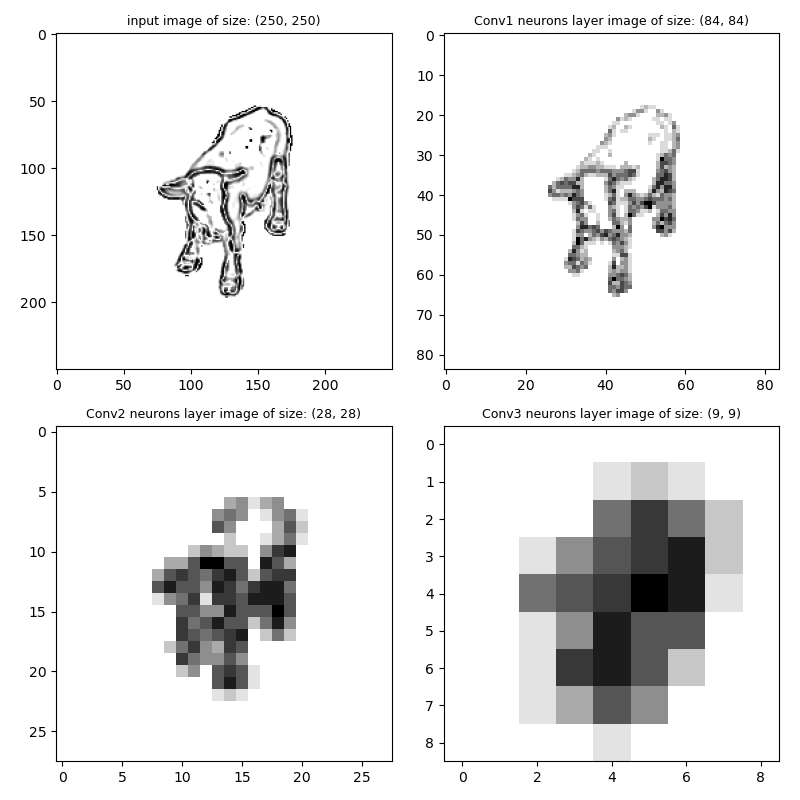

In [ ]:
from IPython.display import Image
Image(filename="cow_conv_img.png")

In [4]:
def input_current_calculator(model_output,model,f_dict,frame_duration=0.1,dt=0.001):

    f0=f_dict["0"]
    f1=f_dict["1"]
    f2=f_dict["2"]
    
    
    out=model_output
    time_steps=out.shape[0]
    
    
    current_values_array=np.zeros((time_steps,3))

    for t in range(time_steps):
        current_values_array[t]=np.array([out[t]@f0,out[t]@f1,out[t]@f2])

    
    time_array=np.arange(0,time_steps*frame_duration,dt)

    current_array=np.empty((len(time_array),3))
    for i,t in enumerate(time_array):

        cnt=int(t//frame_duration)
        current_array[i,:]=current_values_array[cnt,:]

    return current_array, time_array

Here we show the accuracy of the model over images that have not been used to extract the linear feature vectors(f_dict), thus in this regard the precdiction power of model is assessed.

In [ ]:
misclass_list_test=[]
sum=0
for key in output_dict_test.keys():
    misclass_list_test.append([])
    
    for i in range(len(output_dict_test[key])):
    
        currents,tt=input_current_calculator(output_dict_test[key][i],linear_filter_snn_model,f_dict)
    
        label=int(key)
    
        total_signal=currents.sum(axis=0)
    
        pred_label=np.argmax(total_signal)
    
        if label==pred_label:
            sum+=1

        else:
            misclass_list_test[int(key)].append(i)

test_acc=sum/len(test_data)

print("test accuracy over unseen data: ",np.round(test_acc*100,1),"%")

test accuracy over unseen data:  88.2 %


If we did not utilize the linear filter model, and just by using a linear SVM classifier what would be the test accuracy of the output currents of the SNN's last layer

In [15]:
%%capture
#SVM on the entire dataset
from sklearn.svm import LinearSVC
clf = LinearSVC(C=2.4)

X_train=np.empty((len(np.concatenate(images_ordered_pooled,axis=0)),4860))
y_train=np.empty(len(np.concatenate(images_ordered_pooled,axis=0)))

n=0
for i in range(3):

    for j in range(len(output_dict_pooled[str(i)])):

        X_train[i*n+j,:]=(output_dict_pooled[str(i)][j][-1,:]).reshape(-1)
        y_train[i*n+j]=i

    n=len(output_dict_pooled[str(i)])

X_train, X_test, y_train, y_test= train_test_split(X_train,y_train,test_size=0.2, random_state=42,stratify=y_train)    

clf.fit(X_train,y_train)    

y_pred=clf.predict(X_test)   


In [ ]:
print("SVM test accuracy:",np.round((y_pred==y_test).sum()/len(y_test)*100,1),"%")

SVM test accuracy: 91.2 %


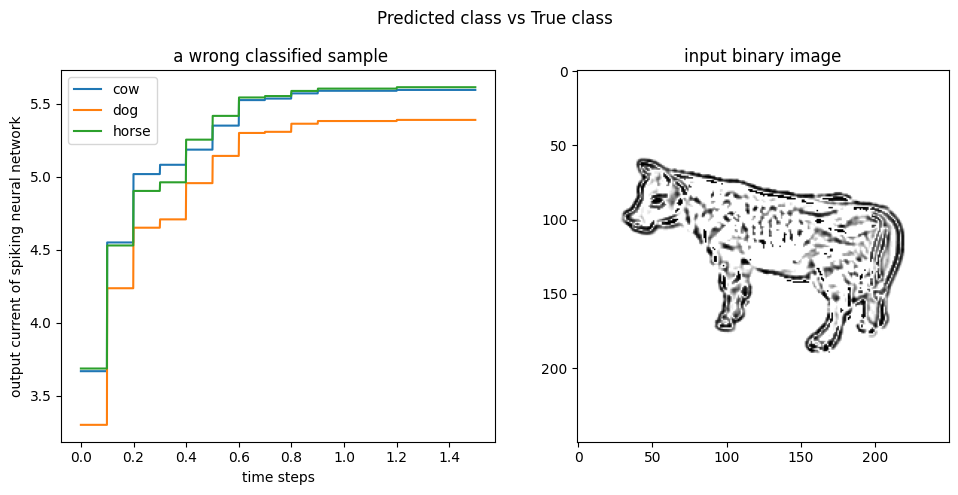

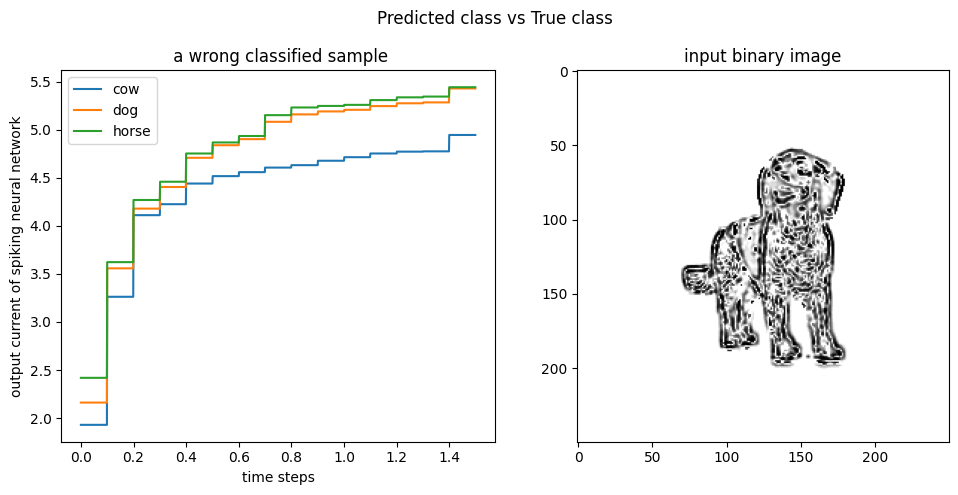

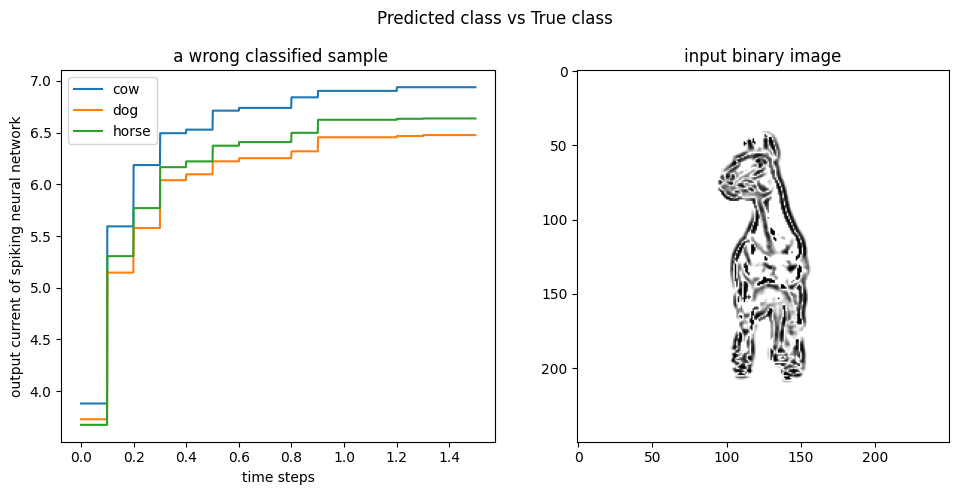

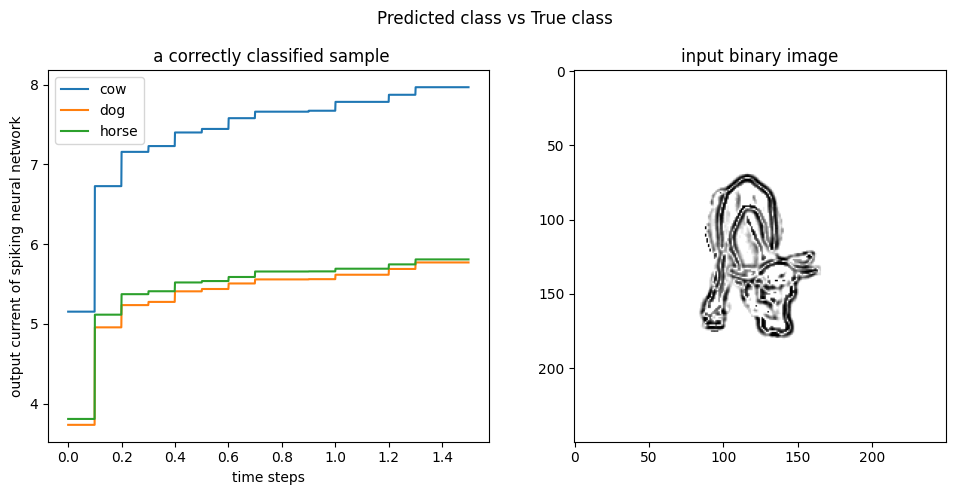

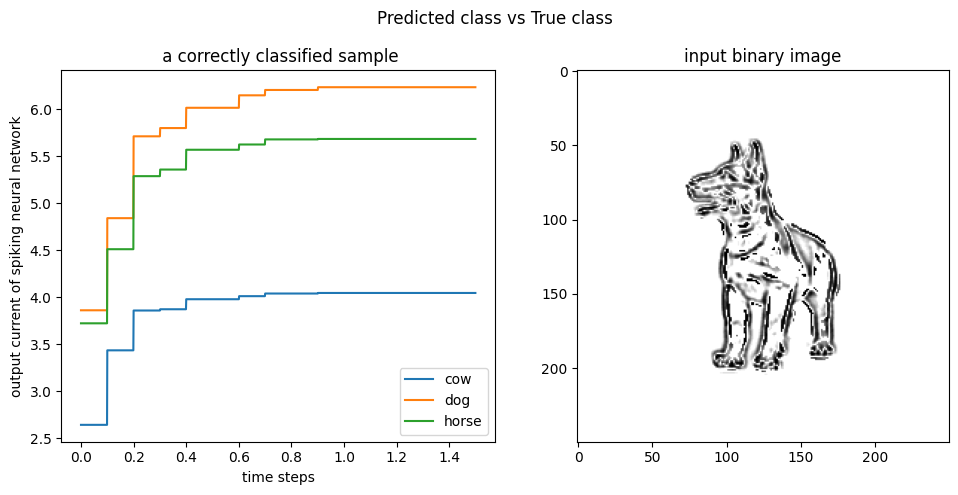

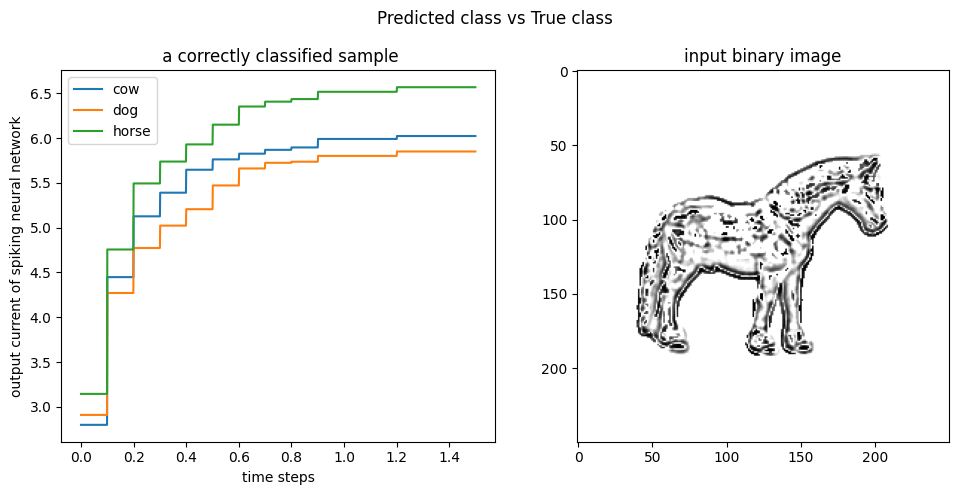

In [36]:
#visualizing output currents
wrong_pred_list=np.array(list(set(misclass_list_test[2]+misclass_list_test[1]+misclass_list_test[0])))
true_pred_list=np.array(list(range(108//3)))
true_pred_list=np.setdiff1d(true_pred_list,wrong_pred_list)

for key in output_dict_test.keys():

    for ind in misclass_list_test[int(key)][-1:]:
        currents,tt=input_current_calculator(output_dict_test[key][ind],linear_filter_snn_model,f_dict)
        #print(train_dataset[i][1])
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title(f" a wrong classified sample")
        plt.plot(tt,currents[:,0],label="cow")
        plt.plot(tt,currents[:,1],label="dog")
        plt.plot(tt,currents[:,2],label="horse")

        plt.ylabel("output current of spiking neural network")
        plt.xlabel("time steps")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title("input binary image")
        plt.imshow(images_ordered_test[int(key)][ind].sum(axis=0).sum(axis=0),cmap="binary")
        
        plt.suptitle("Predicted class vs True class")
        plt.tight_layout()

       
        plt.show()

for key in output_dict_test.keys():

    for ind in true_pred_list[0:1]:
        currents,tt=input_current_calculator(output_dict_test[key][ind],linear_filter_snn_model,f_dict)
        #print(train_dataset[i][1])
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title(f" a correctly classified sample")
        plt.plot(tt,currents[:,0],label="cow")
        plt.plot(tt,currents[:,1],label="dog")
        plt.plot(tt,currents[:,2],label="horse")
        plt.ylabel("output current of spiking neural network")
        plt.xlabel("time steps")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title("input binary image")
        plt.imshow(images_ordered_test[int(key)][ind].sum(axis=0).sum(axis=0),cmap="binary")

        plt.suptitle("Predicted class vs True class")
        plt.tight_layout()
        plt.show()        

With 90% noise applied to a sample image, the output currents lose their distinct structure. See the figure below.

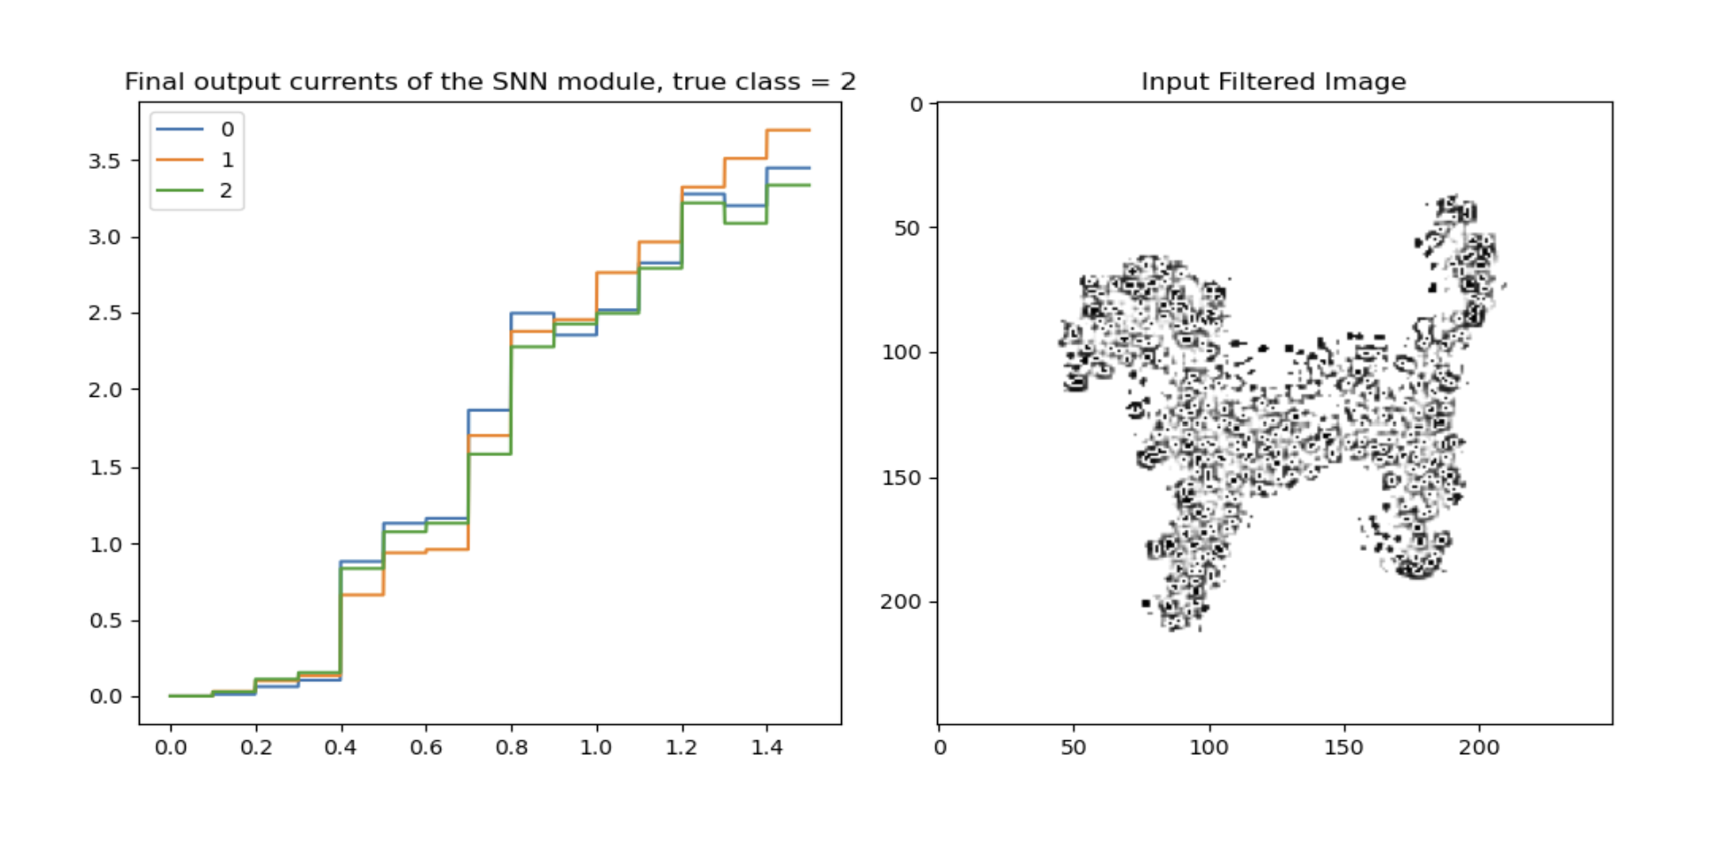

In [10]:
from IPython.display import Image
Image(filename="noisy_input_currents.png")

Finally as an example, for a given image how does the entire triangular DDM look like?

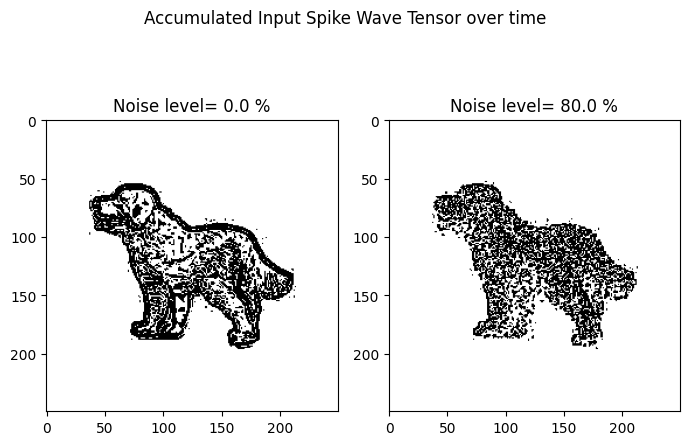

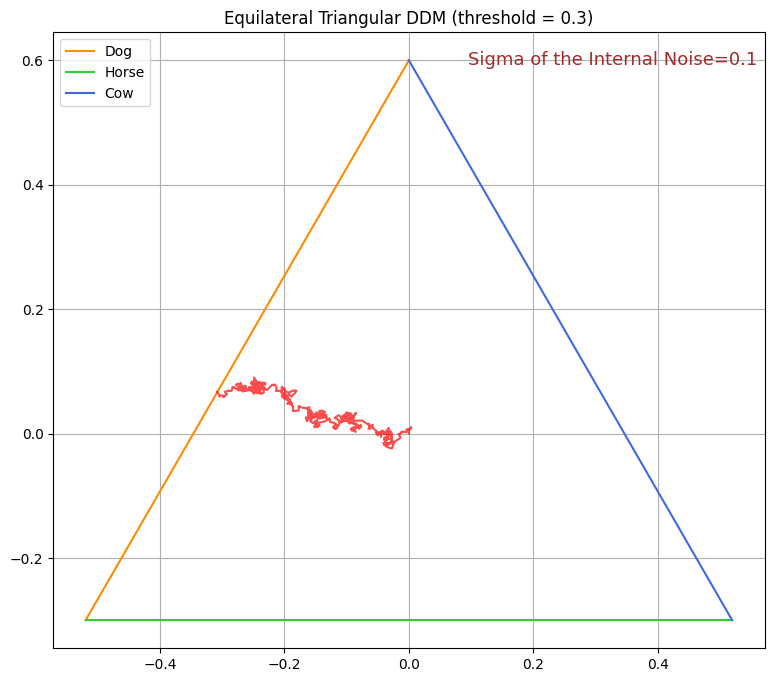

true class=1
predicted class = 1, response time = 0.51, confidence = 0.816


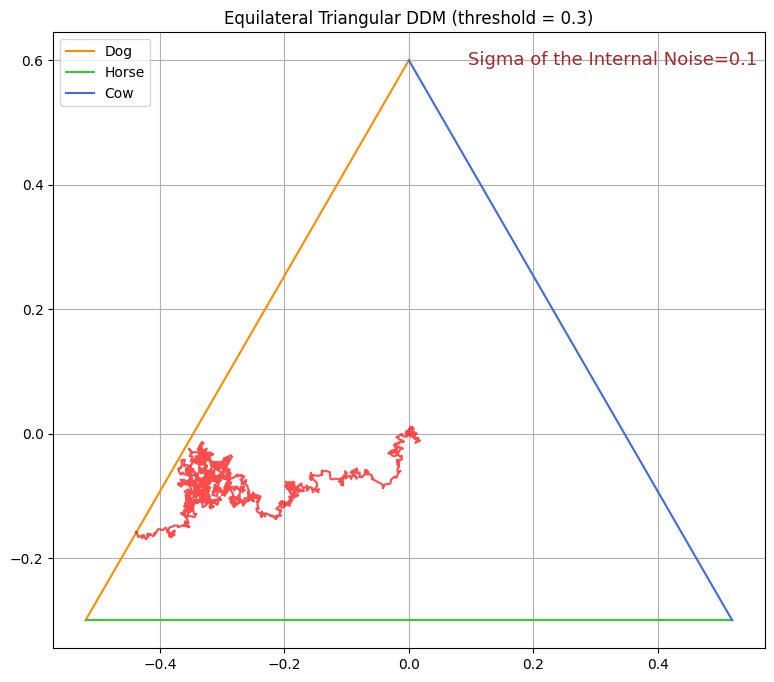

true class = 1
predicted class = 1, response time = 1.764, confidence = 0.315


In [49]:
#a sample image without any noise 
input_path=r"C:\Users\USER\Desktop\Kheradpisheh_ETH\final_data_subjects\final_task_train_noisy\dog\0.00\dog3-090-225-0.00.jpg"
img = Image.open(input_path)
img=img.convert("L")
input_spike_wave=s1(img)

#importing the same image but this time with 80% pepper-like noise
noisy_input_path=r"C:\Users\USER\Desktop\Kheradpisheh_ETH\final_data_subjects\final_task_train_noisy\dog\0.80\dog3-090-225-0.80.jpg"
img_noisy = Image.open(noisy_input_path)
img_noisy=img_noisy.convert("L")
input_spike_wave_noisy=s1(img_noisy)

plt.figure(figsize=(7,5))
plt.subplot(1,2,1,title="Noise level= 0.0 %")
plt.imshow(input_spike_wave[-1].sum(axis=0),cmap="binary")

plt.subplot(1,2,2,title="Noise level= 80.0 %")
plt.imshow(input_spike_wave_noisy[-1].sum(axis=0),cmap="binary")

plt.suptitle("Accumulated Input Spike Wave Tensor over time")

plt.tight_layout()
plt.show()

tri_ddm=model.decide_triangle_DDM(input_spike_wave,threshold=0.3,plot=True)
print(f"true class=1")
print(f"predicted class = {tri_ddm[0]}, response time = {tri_ddm[1]}, confidence = {tri_ddm[2]}")

tri_ddm_noise=model.decide_triangle_DDM(input_spike_wave_noisy,threshold=0.3,plot=True)
print("true class = 1")
print(f"predicted class = {tri_ddm_noise[0]}, response time = {tri_ddm_noise[1]}, confidence = {tri_ddm_noise[2]}")
